In [1]:
import pandas as pd


def load_subcellular_location(min_reliability='Approved'):
    """Subcellular location from Human Protein Atlas
    Args:
        min_reliability ({'Enhanced', 'Supported', 'Approved', 'Uncertain'}): minimum
            threshold to consider. For detailed description see:
            https://www.proteinatlas.org/about/assays+annotation
    Returns:
        DataFrame: indexed by ensembl_gene_id, boolean columns for whether
        protein found in compartment for every celular compartment.
    """
    reliabilities = ['Enhanced', 'Supported', 'Approved', 'Uncertain']
    if min_reliability not in reliabilities:
        raise ValueError(min_reliability + 'not valid value.\n' +
                         'Valid options are: ' + ','.join(reliabilities))
    file_path = ('../../data/external/subcellular_location.tsv')
    df = pd.read_csv(file_path, sep='\t')
    to_use = reliabilities[:reliabilities.index(min_reliability) + 1]
    df['locations'] = df[to_use].apply(lambda x: ';'.join([i for i in x
                                                           if pd.notnull(i)]),
                                       axis=1)
    df = df.loc[df['locations'] != '', :]
    all_locations = set(df['locations'].str.split(';').sum())
    for loc in all_locations:
        df['in_' + loc] = df['locations'].apply(lambda x: loc in x.split(';'))
    df = (df.loc[:, ['Gene'] + ['in_' + i for i in all_locations]]
            .rename(columns={'Gene': 'ensembl_gene_id'}))
    if df['ensembl_gene_id'].duplicated().any():
        raise UserWarning('Unexpected duplicate ensembl gene IDs')
    df = df.set_index('ensembl_gene_id')
    return df


def load_subcellular_location_for_TFs(min_reliability='Approved'):
    df = load_subcellular_location(min_reliability=min_reliability)
    if not (df.sum(axis=1) > 0).all():
        raise UserWarning('Expected at least one location for each gene')
    return df


loc = load_subcellular_location_for_TFs()

In [2]:
loc.head()

,in_Nuclear speckles,in_Endosomes,in_Mitotic spindle,in_Midbody ring,in_Centriolar satellite,in_Cell Junctions,in_Cleavage furrow,in_Mitotic chromosome,in_Nucleoplasm,in_Nucleoli,in_Nuclear membrane,in_Nucleoli rim,in_Mitochondria,in_Plasma membrane,in_Lipid droplets,in_Nuclear bodies,in_Cytoplasmic bodies,in_Endoplasmic reticulum,in_Nucleoli fibrillar center,in_Centrosome,in_Cytokinetic bridge,in_Golgi apparatus,in_Kinetochore,in_Actin filaments,in_Aggresome,in_Rods & Rings,in_Focal adhesion sites,in_Intermediate filaments,in_Vesicles,in_Microtubules,in_Midbody,in_Cytosol,in_Microtubule ends,in_Peroxisomes,in_Lysosomes
ensembl_gene_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
ENSG00000000460,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
ENSG00000000938,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
ENSG00000000971,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
ENSG00000001084,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [3]:
from data_loading import (load_annotated_6k_collection,
 load_annotated_gencode_tfs)

In [4]:
tfs = load_annotated_gencode_tfs()

reading from cache


In [5]:
tf_genes = {tf.ensembl_gene_id for tf in tfs.values()}

In [36]:
print(len(tf_genes), 'TF genes')
print(sum(g in loc.index for g in tf_genes), 
    'have localization data')
print(loc.loc[loc.index.isin(tf_genes), 'in_Cytosol'].sum(),
      'observed in cytosol')

1635 TF genes
1311 have localization data
308 observed in cytosol


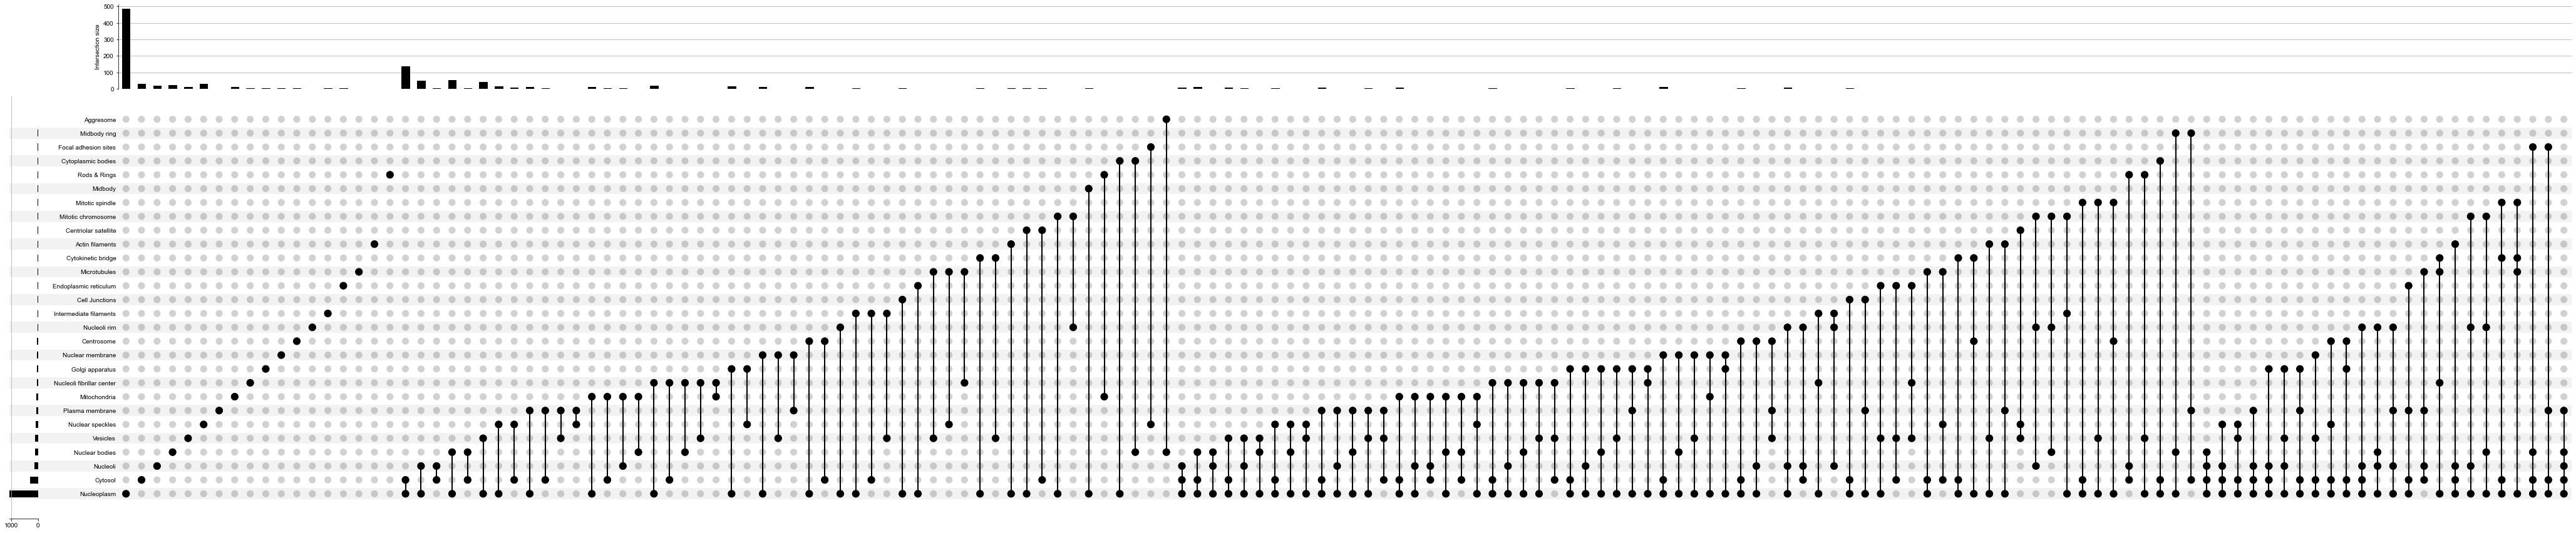

In [38]:
from matplotlib import pyplot as plt
import upsetplot

loc.columns = [c[3:] for c in loc.columns]
cols = list(loc.columns[loc.loc[loc.index.isin(tf_genes), :].any()])
upsetplot.plot(loc.loc[loc.index.isin(tf_genes), cols]
                  .groupby(cols).size())
loc.columns = ["in_" + c for c in loc.columns]
plt.savefig('../../figures/subcellular-localization_gencode_UpSet-plot.pdf',
            bbox_inches='tight')

In [8]:
tfs_cytosol = set(loc[loc.index.isin(tf_genes) & loc['in_Cytosol']].index)
tfs_no_cytosol = set(loc[loc.index.isin(tf_genes) & ~loc['in_Cytosol']].index)

In [73]:
import numpy as np
from scipy import stats

n_iso_cytosol = [len(tf.orfs) for tf in tfs.values() if tf.ensembl_gene_id in tfs_cytosol]
n_iso_no_cytosol = [len(tf.orfs) for tf in tfs.values() if tf.ensembl_gene_id in tfs_no_cytosol]
print(stats.mannwhitneyu(n_iso_cytosol, n_iso_no_cytosol))
print(np.mean(n_iso_cytosol), np.mean(n_iso_no_cytosol))

MannwhitneyuResult(statistic=138691.5, pvalue=0.002426485100707933)
2.9285714285714284 2.5912263210368893


In [66]:
from data_loading import load_dbd_accessions

def has_DBD_loss_isoform(tf):
    if len(tf.orfs) == 1:
        return np.nan
    df = tf.aa_feature_disruption(tf.reference_isoform.name)
    if df.shape[0] == 0:
        return np.nan
    df = df.loc[df['accession'].isin(load_dbd_accessions())]
    if df.shape[0] == 0:
        return np.nan
    return df.loc[:, ['deletion', 'insertion', 'frameshift']].sum().sum() > 0
    

has_DBD_loss_isoform(tfs['ATF2'])

True

In [68]:
# DBD loss isoforms with cytosol location
stats.fisher_exact(
    [[
        sum(has_DBD_loss_isoform(tf) == False for tf in tfs.values()
            if tf.ensembl_gene_id in tfs_cytosol),
        sum(has_DBD_loss_isoform(tf) == True for tf in tfs.values()
            if tf.ensembl_gene_id in tfs_cytosol)

],
                    [
        sum(has_DBD_loss_isoform(tf) == False for tf in tfs.values()
            if tf.ensembl_gene_id in tfs_no_cytosol),
        sum(has_DBD_loss_isoform(tf) == True for tf in tfs.values()
            if tf.ensembl_gene_id in tfs_no_cytosol)
                    ]])


(0.8812922614575507, 0.4899540746780525)

In [69]:
   [[
        sum(has_DBD_loss_isoform(tf) == False for tf in tfs.values()
            if tf.ensembl_gene_id in tfs_cytosol),
        sum(has_DBD_loss_isoform(tf) == True for tf in tfs.values()
            if tf.ensembl_gene_id in tfs_cytosol)

],
                    [
        sum(has_DBD_loss_isoform(tf) == False for tf in tfs.values()
            if tf.ensembl_gene_id in tfs_no_cytosol),
        sum(has_DBD_loss_isoform(tf) == True for tf in tfs.values()
            if tf.ensembl_gene_id in tfs_no_cytosol)
                    ]]

[[68, 121], [220, 345]]

In [71]:
len(cloned_tf_genes)

309

In [72]:
cloned_tf_genes = {tf.ensembl_gene_id for tf in load_annotated_6k_collection().values() if len(tf.orfs) > 1}
print(len(cloned_tf_genes), 'TF genes with at least 2 cloned isoforms')
print(sum(g in loc.index for g in cloned_tf_genes), 
    'have localization data')
print(loc.loc[loc.index.isin(cloned_tf_genes), 'in_Cytosol'].sum(),
      'observed in cytosol')

reading from cache
298 TF genes with at least 2 cloned isoforms
267 have localization data
67 observed in cytosol


In [9]:
# difference in activation, PPIs and PDIs for
# TFs in cytosol
from data_loading import *
from isoform_pairwise_metrics import *

y2h = load_isoform_and_paralog_y2h_data()
y2h = y2h.loc[y2h['category'].isin(['tf_isoform_ppis',
                                    'tf_paralog_ppis',
                                    'non_paralog_control',
                                    'paralog_with_PDI']),
              :]
y1h = load_y1h_pdi_data()
m1h = load_m1h_activation_data()
isoforms = load_valid_isoform_clones()
df = pairs_of_isoforms_comparison_table(isoforms, y2h=y2h, y1h=y1h, m1h=m1h)

In [75]:
df.head()

,tf_gene_symbol,clone_acc_a,clone_acc_b,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,ppi_delta_n,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,pdi_delta_n,activation_fold_change,activation_abs_fold_change,aa_seq_pct_id
pair,,,,,,,,,,,,,,,,,,,,,,
AEBP2|2/3|05F03_AEBP2|3/3|05E07,AEBP2,AEBP2|2/3|05F03,AEBP2|3/3|05E07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.535619,0.535619,82.0
ARNT2|1/6|08C12_ARNT2|2/6|09E01,ARNT2,ARNT2|1/6|08C12,ARNT2|2/6|09E01,11.0,7.0,7.0,0.0,0.636364,1.0,4.0,-4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.094800,2.094800,93.0
ARNT2|1/6|08C12_ARNT2|3/6|10D11,ARNT2,ARNT2|1/6|08C12,ARNT2|3/6|10D11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.7
ARNT2|2/6|09E01_ARNT2|3/6|10D11,ARNT2,ARNT2|2/6|09E01,ARNT2|3/6|10D11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.1
ARNTL|1/2|08H08_ARNTL|2/2|08E08,ARNTL,ARNTL|1/2|08H08,ARNTL|2/2|08E08,2.0,0.0,0.0,0.0,0.000000,NaN,2.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.3


In [10]:
ref_isos = {tf.cloned_reference_isoform.clone_acc for tf in load_annotated_6k_collection().values()}
df['is_reference_comparison'] = (df['clone_acc_a'].isin(ref_isos) | 
                                 df['clone_acc_b'].isin(ref_isos))

reading from cache


In [14]:
df['ensembl_gene_id'] = df['tf_gene_symbol'].map({tf.name: tf.ensembl_gene_id for tf in load_annotated_6k_collection().values()})

reading from cache


In [15]:
df['ensembl_gene_id'].isnull().any()

True

In [16]:
# FIXME why is this missing?
df.loc[df['ensembl_gene_id'].isnull()]

,tf_gene_symbol,clone_acc_a,clone_acc_b,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,ppi_delta_n,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,pdi_delta_n,activation_fold_change,activation_abs_fold_change,aa_seq_pct_id,is_reference_comparison,ensembl_gene_id
pair,,,,,,,,,,,,,,,,,,,,,,,,
PCGF6|1/2|11A10_PCGF6|2/2|11B07,PCGF6,PCGF6|1/2|11A10,PCGF6|2/2|11B07,1.0,0.0,0.0,0.0,0.0,NaN,1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.320717,4.320717,78.4,False,NaN


In [18]:
def in_cytosol(ensembl_gene_id):
    if ensembl_gene_id in tfs_cytosol:
        return True
    elif ensembl_gene_id in tfs_no_cytosol:
        return False
    else:
        return np.nan

df['in_cytosol'] = df['ensembl_gene_id'].apply(in_cytosol)

In [43]:
df.loc[df['is_reference_comparison'] & df['ppi_jaccard'].notnull(), :].head()

,tf_gene_symbol,clone_acc_a,clone_acc_b,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,ppi_delta_n,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,pdi_delta_n,activation_fold_change,activation_abs_fold_change,aa_seq_pct_id,is_reference_comparison,ensembl_gene_id,in_cytosol
pair,,,,,,,,,,,,,,,,,,,,,,,,,
ARNT2|1/6|08C12_ARNT2|2/6|09E01,ARNT2,ARNT2|1/6|08C12,ARNT2|2/6|09E01,11.0,7.0,7.0,0.0,0.636364,1.0,4.0,-4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.094800,2.094800,93.0,True,ENSG00000172379,False
ARNTL|1/2|08H08_ARNTL|2/2|08E08,ARNTL,ARNTL|1/2|08H08,ARNTL|2/2|08E08,2.0,0.0,0.0,0.0,0.000000,NaN,2.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.3,True,ENSG00000133794,False
ARNTL2|1/5|10H01_ARNTL2|2/5|12C06,ARNTL2,ARNTL2|1/5|10H01,ARNTL2|2/5|12C06,2.0,2.0,2.0,0.0,1.000000,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.6,True,ENSG00000029153,False
ARNTL2|2/5|12C06_ARNTL2|3/5|10B01,ARNTL2,ARNTL2|2/5|12C06,ARNTL2|3/5|10B01,2.0,2.0,2.0,0.0,1.000000,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.137769,0.137769,87.0,True,ENSG00000029153,False
ARNTL2|2/5|12C06_ARNTL2|4/5|09F12,ARNTL2,ARNTL2|2/5|12C06,ARNTL2|4/5|09F12,2.0,0.0,0.0,0.0,0.000000,NaN,2.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.0,True,ENSG00000029153,False


Ks_2sampResult(statistic=0.17222222222222222, pvalue=0.4716400582328977)

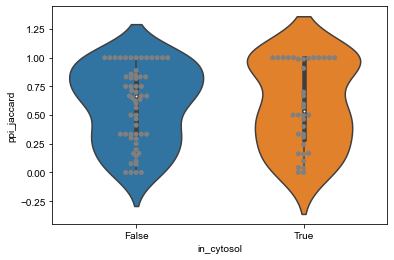

In [44]:
import seaborn as sns
from scipy import stats
# TODO: at least 2 PPIs and at least some interactions each???
# TODO: print number of genes
data = df.loc[df['is_reference_comparison'] & df['ppi_jaccard'].notnull() & (df['ppi_n_min'] >= 1), :]
sns.swarmplot(data=data,
              x='in_cytosol',
              y='ppi_jaccard',
              color='grey')
sns.violinplot(data=data,
              x='in_cytosol',
              y='ppi_jaccard')

stats.ks_2samp(data.loc[data['in_cytosol'] == True, 'ppi_jaccard'].values,
               data.loc[data['in_cytosol'] == False, 'ppi_jaccard'].values
)

Ks_2sampResult(statistic=0.2279874213836478, pvalue=0.6021257062451526)

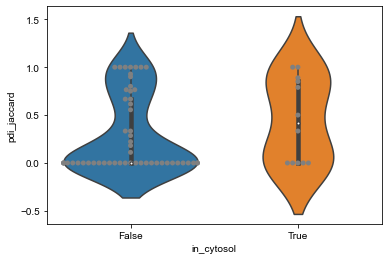

In [46]:
data = df.loc[df['is_reference_comparison'] & df['pdi_jaccard'].notnull(), :]
sns.swarmplot(data=data,
              x='in_cytosol',
              y='pdi_jaccard',
              color='grey')
sns.violinplot(data=data,
              x='in_cytosol',
              y='pdi_jaccard')

stats.ks_2samp(data.loc[data['in_cytosol'] == True, 'pdi_jaccard'].values,
               data.loc[data['in_cytosol'] == False, 'pdi_jaccard'].values)

Ttest_indResult(statistic=-1.6998314632102665, pvalue=0.09022026391113029)

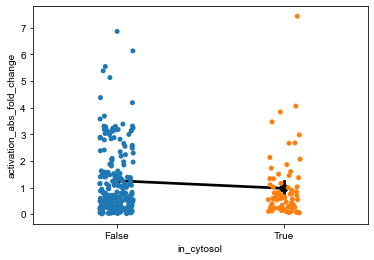

In [49]:
data = df.loc[df['is_reference_comparison'] & df['activation_abs_fold_change'].notnull(), :]

sns.stripplot(data=data,
              x='in_cytosol',
              y='activation_abs_fold_change')
sns.pointplot(data=data,
              x='in_cytosol',
              y='activation_abs_fold_change',
              color='black',
              zorder=99999)

stats.ttest_ind(data.loc[data['in_cytosol'] == True, 'activation_abs_fold_change'].values,
               data.loc[data['in_cytosol'] == False, 'activation_abs_fold_change'].values)

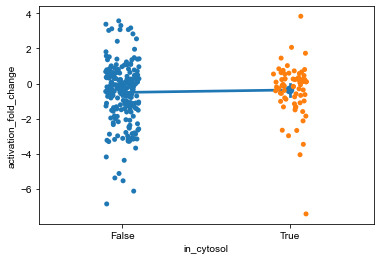

In [27]:
# don't think this uses the reference as reference
sns.stripplot(data=df.loc[df['is_reference_comparison'], :],
              x='in_cytosol',
              y='activation_fold_change')
sns.pointplot(data=df.loc[df['is_reference_comparison'], :],
              x='in_cytosol',
              y='activation_fold_change')

In [58]:
from collections import Counter
Counter(tf.chrom for tf in tfs.values() if tf.tf_family == 'Nuclear receptor')

Counter({'chr1': 5,
         'chr2': 1,
         'chr3': 6,
         'chr4': 1,
         'chr5': 2,
         'chr6': 4,
         'chr8': 1,
         'chr9': 5,
         'chr11': 3,
         'chr12': 5,
         'chr14': 2,
         'chr15': 3,
         'chr17': 3,
         'chr19': 2,
         'chr20': 1,
         'chr22': 1,
         'chrX': 1})

In [62]:
tab = [[sum(tf.ensembl_gene_id in tfs_cytosol for tf in tfs.values() 
    if tf.tf_family == 'Nuclear receptor'),
sum(tf.ensembl_gene_id in tfs_no_cytosol for tf in tfs.values() 
    if tf.tf_family == 'Nuclear receptor')],
    [sum(tf.ensembl_gene_id in tfs_cytosol for tf in tfs.values() 
    if tf.tf_family != 'Nuclear receptor'),
sum(tf.ensembl_gene_id in tfs_no_cytosol for tf in tfs.values() 
    if tf.tf_family != 'Nuclear receptor')],]
print(tab)
print(stats.fisher_exact(tab))

[[13, 28], [295, 975]]
(1.534503631961259, 0.25961511397196824)
